In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

In [7]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print("EI:",ei)

Upper bound is 2.615513154909303
Lower bound is -1.5889377122574324
pdf upper is 0.013044442930869982
cdf upper is 0.995545325539457
pdf lower is 0.11289466536450131
cdf lower is 0.05603722796046923
EI: [-47.6990669   -1.26439802  -5.219299   -16.3243213   -5.87386884
  -4.45315281]


In [8]:
Integrand_values = improvement(best_error,model_mean,model_variance,y_exp)
print("Lower Improvement Integrand is \n",Integrand_values[0] )
print("Upper Improvement Integrand is \n",Integrand_values[1] )

Lower Improvement Integrand is 
 [-13.55761922  -1.7153442   -3.88439771   0.          -3.87433571
  -3.35534918]
Upper Improvement Integrand is 
 [ 0.         -0.62991635 -0.31847227 -1.76362435 -0.24963952 -0.28100008]


In [9]:
#Test calc_ei_adv (to compare with hand calcs)
import numpy as np
import torch
er_best = 2.0 #IF this changes to 2 the sign of the integrand changes
mu = torch.tensor([3])
y_exp2 = np.array([4])
pred_var = torch.tensor([1])
print("EI:",calc_ei_advanced(er_best,mu,pred_var,y_exp2))

Upper bound is 2.414213562373095
Lower bound is -0.41421356237309515
pdf upper is 0.021641292583382807
cdf upper is 0.9921153917769587
pdf lower is 0.36614532160079927
cdf lower is 0.339358855094689
EI: [-0.11799097]


Improvement is [-5.05484635e-05]


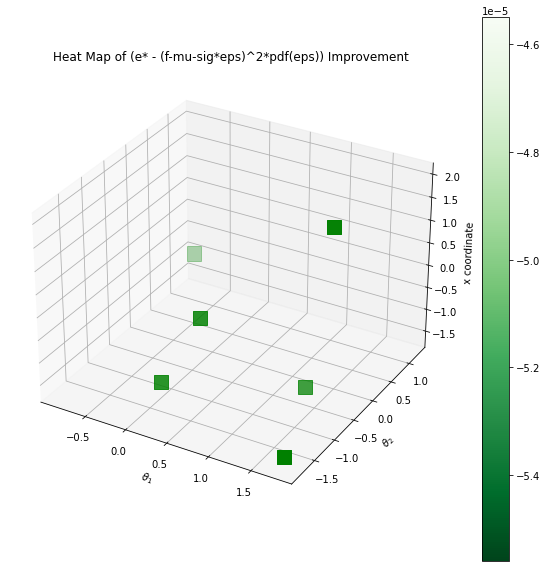

None


In [10]:
eps = -5
I = improvement(er_best,mu,pred_var,y_exp2,eps)
print("Improvement is", I)
print(improvement_plot(test_p,I))

Integrand: [array([-5.05484635e-05]), array([-0.0045432]), array([-0.10334574]), array([-0.50843871]), array([-0.14351035]), array([0.61625031]), array([0.15474222]), array([-0.00977314]), array([-0.00131635]), array([-2.08140732e-05])]
Integrand Lower: [-1.62601187e-16]
Integrand Upper: [9.61066452e-18]


Text(0, 0.5, 'Improvement Integrand')

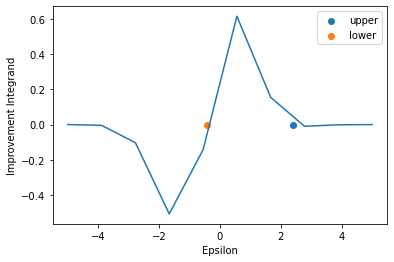

In [11]:
EPS = np.linspace(-5,5,10)
EPS_upper = ((y_exp2 - mu.numpy()) +np.sqrt(er_best))/np.sqrt(pred_var.numpy())
integrand_upper = improvement(er_best,mu,pred_var,y_exp2,EPS_upper)
EPS_lower = ((y_exp2 - mu.numpy()) -np.sqrt(er_best))/np.sqrt(pred_var.numpy())
integrand_lower = improvement(er_best,mu,pred_var,y_exp2,EPS_lower)

I_test = []
for i in range(len(EPS)):
    I_i = I = improvement(er_best,mu,pred_var,y_exp2,EPS[i])
    I_test.append(I_i)
print("Integrand:", I_test) 
print("Integrand Lower:",integrand_lower )
print("Integrand Upper:",integrand_upper )

from matplotlib import pyplot as plt    
plt.plot(EPS,I_test)
plt.scatter(EPS_upper,integrand_upper, label="upper")
plt.scatter(EPS_lower,integrand_lower, label ="lower")
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Improvement Integrand")

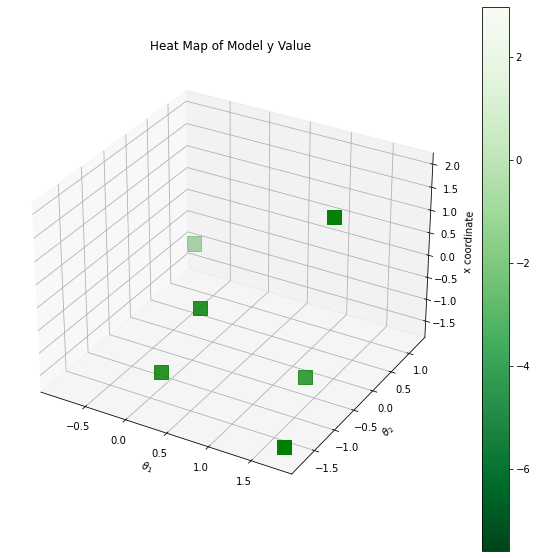

None


In [12]:
y_title = "Model y Value"
print(y_plotter_adv(test_p, model_y, y_title))

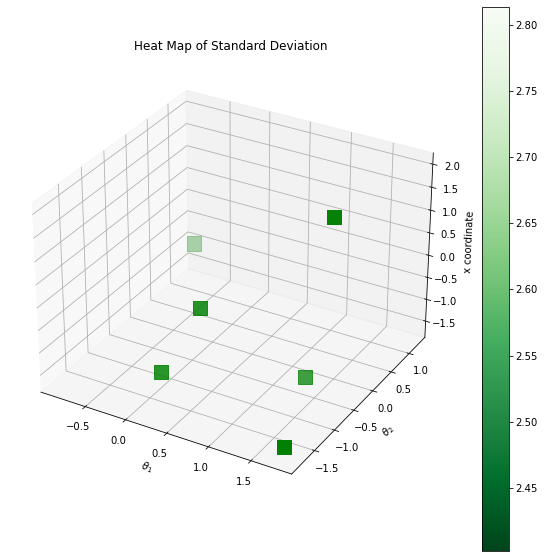

None


In [13]:
print(stdev_plotter_adv(test_p, model_stdev))

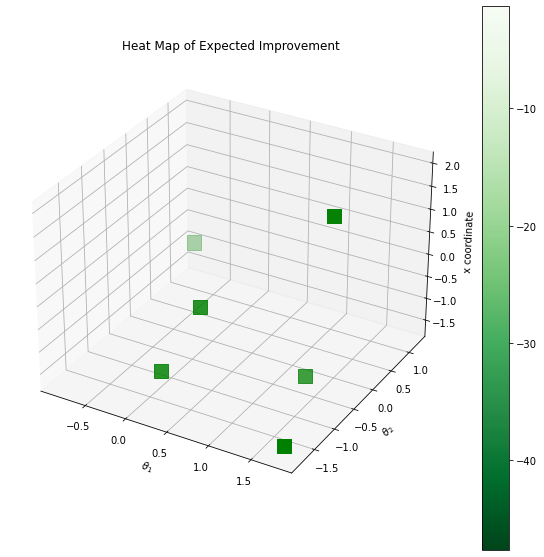

None


In [14]:
print(ei_plotter_adv(test_p, ei))